Analysis of Covid-19 based on available data from relevant governments.
This model is based on the work of Gianluca Malato:
https://towardsdatascience.com/covid-19-infection-in-italy-mathematical-models-and-predictions-7784b4d7dd8d

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from sklearn.metrics import mean_squared_error
from scipy.optimize import curve_fit
from scipy.optimize import fsolve
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

In [83]:
#Italian data
df = pd.read_csv("dpc-covid19-ita-andamento-nazionale.csv")
df = pd.read_csv("https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-andamento-nazionale/dpc-covid19-ita-andamento-nazionale.csv")

In [84]:
df

,data,stato,ricoverati_con_sintomi,terapia_intensiva,totale_ospedalizzati,isolamento_domiciliare,totale_attualmente_positivi,nuovi_attualmente_positivi,dimessi_guariti,deceduti,totale_casi,tamponi
0,2020-02-24 18:00:00,ITA,101,26,127,94,221,221,1,7,229,4324
1,2020-02-25 18:00:00,ITA,114,35,150,162,311,90,1,10,322,8623
2,2020-02-26 18:00:00,ITA,128,36,164,221,385,74,3,12,400,9587
3,2020-02-27 18:00:00,ITA,248,56,304,284,588,203,45,17,650,12014
4,2020-02-28 18:00:00,ITA,345,64,409,412,821,233,46,21,888,15695
5,2020-02-29 18:00:00,ITA,401,105,506,543,1049,228,50,29,1128,18661
6,2020-03-01 18:00:00,ITA,639,140,779,798,1577,528,83,34,1694,21127
7,2020-03-02 18:00:00,ITA,742,166,908,927,1835,258,149,52,2036,23345
8,2020-03-03 18:00:00,ITA,1034,229,1263,1000,2263,428,160,79,2502,25856
9,2020-03-04 18:00:00,ITA,1346,295,1641,1065,2706,443,276,107,3089,29837


In [85]:
# totale_casi contains the cumulative number of infected people to date.
df = df.loc[:,['data', 'totale_casi']]

In [86]:
date = df['data']

In [87]:
# get the number of days since the start of the year
FMT = '%Y-%m-%d %H:%M:%S'
df['data'] = date.map(lambda x : (datetime.strptime(x, FMT) - datetime.strptime("2020-01-01 00:00:00", FMT)).days)

In [88]:
df

,data,totale_casi
0,54,229
1,55,322
2,56,400
3,57,650
4,58,888
5,59,1128
6,60,1694
7,61,2036
8,62,2502
9,63,3089


In [89]:
df_g = df
df_g['Change'] = df_g['totale_casi'] - df_g['totale_casi'].shift(1)
df_g['Growth Factor'] = df_g['Change']/df_g['Change'].shift(1)

In [90]:
# logistic model
def logistic_model(x,a,b,c):
    return c / (1 + np.exp(-(x-b)/a))

In [91]:
#use curve_fit from scipy to estimate the parameter values and errors from data
x = list(df.iloc[:,0])
y = list(df.iloc[:,1])

In [101]:
fit = curve_fit(logistic_model, x, y, p0=[3,108,40000])
fit

(array([4.11962811e+00, 7.35212189e+01, 4.23935016e+04]),
 array([[3.47656751e-02, 2.22038898e-01, 1.37659045e+03],
        [2.22038898e-01, 1.55021033e+00, 9.79512469e+03],
        [1.37659045e+03, 9.79512469e+03, 6.22277226e+07]]))

In [93]:
# a is the infection speed
# b is the day with maximum infections
# c is the total number of recorded infected people at the infection's end.

In [94]:
# look at the covariance matrix
errors = [np.sqrt(fit[1][i][i]) for i in [0,1,2]]

In [95]:
errors

[0.1864555557840705, 1.2450712947084392, 7888.405071110006]

In [104]:
# infection end day
a = fit[0][0]
b = fit[0][1]
c = fit[0][2]
sol = int(fsolve(lambda x : logistic_model(x,a,b,c) - int(c), b))
sol

120

In [97]:
startOfYear = datetime(2020,1,1)

endDay = startOfYear + timedelta(days=sol)
endDay

datetime.datetime(2020, 4, 30, 0, 0)

In [98]:
#exponential model
def exponential_model(x,a,b,c):
    return a*np.exp(b*(x-c))

In [99]:
exp_fit = curve_fit(exponential_model,x,y,p0=[0.01,0.2,0.5])
exp_fit

(array([0.01181177, 0.19846466, 0.061657  ]),
 array([[ 2.81435095e+03, -3.15105076e-01,  1.20089094e+06],
        [-3.15105076e-01,  5.73553819e-05, -1.34448499e+02],
        [ 1.20089094e+06, -1.34448499e+02,  5.12423318e+08]]))

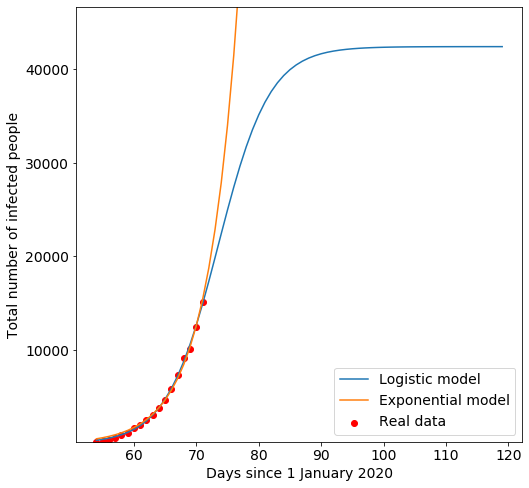

In [100]:
plt.rcParams['figure.figsize'] = [8,8]

plt.rc('font', size=14)
pred_x = list(range(max(x),sol))

plt.scatter(x,y,label="Real data", color="red")
plt.plot(x+pred_x, [logistic_model(i,fit[0][0],fit[0][1],fit[0][2]) for i in x+pred_x], label="Logistic model" )
# Predicted exponential curve
plt.plot(x+pred_x, [exponential_model(i,exp_fit[0][0],exp_fit[0][1],exp_fit[0][2]) for i in x+pred_x], label="Exponential model" )
plt.legend()
plt.xlabel("Days since 1 January 2020")
plt.ylabel("Total number of infected people")
plt.ylim((min(y)*0.9,c*1.1));

British data as per GOV website

In [39]:
df2 = pd.read_csv("DailyConfirmedCases-12Mar2020.csv")

In [40]:
df2

,DateVal,CMODateCount,CumCases
0,31/01/2020,2,2
1,01/02/2020,0,2
2,02/02/2020,0,2
3,03/02/2020,0,2
4,04/02/2020,0,2
5,05/02/2020,0,2
6,06/02/2020,1,3
7,07/02/2020,0,3
8,08/02/2020,0,3
9,09/02/2020,1,4


In [41]:
format = '%d/%m/%Y'
df2 = df2.loc[:,['DateVal', 'CumCases']]
df2['DateVal'] =  pd.to_datetime(df2['DateVal'], format=format)

In [42]:
#df2 = df2[df2['DateVal'] >= datetime(2020,2,9)]
firstDate = df2['DateVal'].iloc[0]
firstDate

Timestamp('2020-01-31 00:00:00')

In [43]:
df2_date = df2['DateVal']
df2['Days'] = df2_date.map(lambda x : (x - firstDate).days)

In [44]:
#df2 = df2.append({'DateVal': datetime(2020,3,11), 'CumCases': 456, 'Days': 40}, ignore_index=True)

In [45]:
x2 = list(df2.iloc[:,2])
y2 = list(df2.iloc[:,1])

In [102]:
fit2 = curve_fit(logistic_model,x2,y2,p0=[2.6,73,2000])

In [103]:
fit2

(array([   3.45240589,   42.32568597, 1415.69587715]),
 array([[3.30288114e-02, 1.81069177e-01, 4.24277182e+01],
        [1.81069177e-01, 1.09747178e+00, 2.62421746e+02],
        [4.24277182e+01, 2.62421746e+02, 6.31571816e+04]]))

In [48]:
# infection end day
a2 = fit2[0][0]
b2 = fit2[0][1]
c2 = fit2[0][2]
sol2 = int(fsolve(lambda x : logistic_model(x,a2,b2,c2) - int(c2), b2))
a2,b2,c2
exp_fit2 = curve_fit(exponential_model,x2,y2,p0=[.1,0.2,0.5])
exp_fit2

(array([0.07726215, 0.2284882 , 1.83745797]),
 array([[ 1.56491387e+09, -2.38292550e+02,  8.86015179e+10],
        [-2.38292536e+02,  6.27926736e-05, -1.34915243e+04],
        [ 8.86015179e+10, -1.34915251e+04,  5.01639683e+12]]))

In [59]:
sol2
max(x2)
x2_plus = list(range(max(x2)+1,max(x2)+11))
x2_plus

[42, 43, 44, 45, 46, 47, 48, 49, 50, 51]

In [112]:
exp_model_predict = [exponential_model(i,exp_fit2[0][0],exp_fit2[0][1],exp_fit2[0][2]) for i in x2_plus]
exp_model_predict = [int(i) for i in exp_model_predict]
x2_predict = x2 + x2_plus
y2_predict = y2 + exp_model_predict
x2_predict, y2_predict
# now pass these to the logistic model and see what comes out
#fit_logistic_predict = curve_fit(logistic_model,x2_predict,y2_predict,p0=[3,73,9000])
#fit_logistic_predict

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51],
 [2,
  2,
  2,
  2,
  2,
  2,
  3,
  3,
  3,
  4,
  8,
  8,
  8,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  13,
  13,
  13,
  13,
  19,
  23,
  35,
  40,
  51,
  85,
  114,
  160,
  206,
  271,
  321,
  373,
  456,
  590,
  747,
  938,
  1179,
  1482,
  1863,
  2341,
  2942,
  3697,
  4647,
  5840])

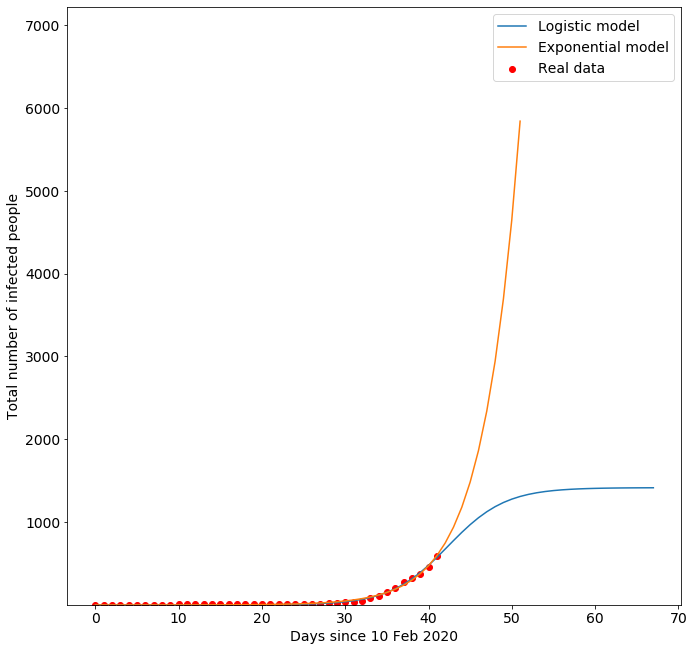

In [53]:
plt.rcParams['figure.figsize'] = [11,11]

plt.rc('font', size=14)
pred_x2 = list(range(max(x2),sol2))

plt.scatter(x2,y2,label="Real data", color="red")
plt.plot(x2+pred_x2, [logistic_model(i,fit2[0][0],fit2[0][1],fit2[0][2]) for i in x2+pred_x2], label="Logistic model" )
# Predicted exponential curve
plt.plot(x2+x2_plus, [exponential_model(i,exp_fit2[0][0],exp_fit2[0][1],exp_fit2[0][2]) for i in x2+x2_plus], label="Exponential model" )
plt.legend()
plt.xlabel("Days since 10 Feb 2020")
plt.ylabel("Total number of infected people")
plt.ylim((min(y2)*0.9,c2*5.1));

In [54]:
sol2

68

# johns hopkins data
https://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data/csse_covid_19_daily_reports

https://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data/csse_covid_19_time_series

In [35]:
df_confirmed = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv')

In [36]:
df_confirmed.head(5)

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20
0,NaN,Thailand,15.0000,101.0000,2,3,5,7,8,8,...,43,43,43,47,48,50,50,50,53,59
1,NaN,Japan,36.0000,138.0000,2,1,2,2,4,4,...,274,293,331,360,420,461,502,511,581,639
2,NaN,Singapore,1.2833,103.8333,0,1,3,3,4,5,...,108,110,110,117,130,138,150,150,160,178
3,NaN,Nepal,28.1667,84.2500,0,0,0,1,1,1,...,1,1,1,1,1,1,1,1,1,1
4,NaN,Malaysia,2.5000,112.5000,0,0,0,3,4,4,...,29,36,50,50,83,93,99,117,129,149


In [37]:
id_list = df_confirmed.columns.to_list()[:4]
vars_list = df_confirmed.columns.to_list()[4:]
df_confirmed_clean = pd.melt(df_confirmed, id_vars=id_list,value_vars=vars_list, var_name='Date', value_name='Confirmed')

In [38]:
df_confirmed_clean.head(5)

,Province/State,Country/Region,Lat,Long,Date,Confirmed
0,NaN,Thailand,15.0000,101.0000,1/22/20,2
1,NaN,Japan,36.0000,138.0000,1/22/20,2
2,NaN,Singapore,1.2833,103.8333,1/22/20,0
3,NaN,Nepal,28.1667,84.2500,1/22/20,0
4,NaN,Malaysia,2.5000,112.5000,1/22/20,0
